<b><font size = "5"> Week 3 Assignment </b>

This week we continue with modelling the longevity of NBA players.

1. Hyper-parameter tuning of logit model
2. SVC model

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from joblib import dump
from sklearn.svm import SVC
from mlxtend.evaluate import feature_importance_permutation

<b> 1. Hyper-parameter tuning of logit model with correlated features removed </b>

From last week's exercise, it was found that removing correlated features (FGM, FGA, 3P Made, 3PA, FTM, FTA, and REB)
improved AUC. We will continue with this reduced dataset this week.

We will also further expand on last week's logit model by tuning the hyperparameters of the model

In [29]:
scaler = joblib.load('../models/scaler.joblib')
train_test_split = joblib.load('../models/train_test_split.joblib')

train_test_split
df=pd.read_csv('../data/raw/train.csv')
df_analysis=df.drop(columns=["Id_old","Id"])
#Pop into a new variable the target column
target = df_analysis.pop('TARGET_5Yrs')
#Remove the correlated features and scale the variables
df_analysis_reduce = df_analysis.drop(columns=["FGM","FGA","3P Made","3PA","FTM","FTA","REB"])
df_scaled_reduce = scaler.fit_transform(df_analysis_reduce)
#Split into train and validation set
X_train_reduce, X_valid_reduce, y_train_reduce, y_valid_reduce = train_test_split (df_scaled_reduce, target, test_size=0.2, random_state=8)


The following section will try to find the best parameters for a logistic regression model with L1 regularisation

Class weight is set as balanced, because last week's exercise showed that balancing the training set balances the accuracy
for both >=5 years and <5 years.

In [224]:
#Define space for logit parameters to be tuned

#If L1 regularisation
space_l1 = {
   'C' : hp.uniform('C', 0, 100),
'solver': hp.choice('solver',['liblinear','saga']),
}


In [225]:
def objective_l1(space_l1):
   logit_model = LogisticRegression(
       penalty = 'l1',
       C = space_l1['C'],
       solver = space_l1['solver'],
       class_weight = 'balanced'
   )
   logit_model.fit(X_train_reduce, y_train_reduce)
   auc = metrics.roc_auc_score(y_valid_reduce, logit_model.predict_proba(X_valid_reduce)[::,1])
   return{'loss': 1-auc, 'status': STATUS_OK }


In [226]:
best_l1 = fmin(
   fn=objective_l1,  
   space=space_l1,      
   algo=tpe.suggest,      
   max_evals=1000
)
best_l1

100%|██████████| 1000/1000 [01:40<00:00,  9.95trial/s, best loss: 0.29283415084991793]


{'C': 0.16561217478583887, 'solver': 1}

Hyper-opts parameter tuning above shows that by setting C = 0.1656 and solver = saga, the auc can be optimised to 0.707
with an L1 regularisation.

The next section will attempt to find the optimal C and solver for an L2 regularisation

In [213]:
#if L2 regularisation
space_l2 = {
   'C' : hp.uniform('C', 0, 100),
'solver': hp.choice('solver',['newton-cg','lbfgs','sag','saga'])
}

In [214]:
def objective_l2(space_l2):
   logit_model = LogisticRegression(
       penalty = 'l2',
       C = space_l2['C'],
       solver = space_l2['solver'],
       class_weight = 'balanced'
   )
   logit_model.fit(X_train_reduce, y_train_reduce)
   auc = metrics.roc_auc_score(y_valid_reduce, logit_model.predict_proba(X_valid_reduce)[::,1])
   return{'loss': 1-auc, 'status': STATUS_OK }

In [215]:
best_l2 = fmin(
   fn=objective_l2,  
   space=space_l2,      
   algo=tpe.suggest,      
   max_evals=1000
)
best_l2

100%|██████████| 1000/1000 [01:27<00:00, 11.40trial/s, best loss: 0.29168392964238843]


{'C': 0.00480719434510272, 'solver': 1}

Hyper-opts parameter tuning above shows that by setting C = 0.0048 and solver = lbfgs, the auc can be optimised to 0.708 with an L2 regularisation.

The next section will attempt to find the best parameters for logit model with elasticnet regularisation

In [ ]:
#if elasticnet regularisation 

space_elastic = {
   'C' : hp.uniform('C', 0, 100),
'solver': hp.choice('solver',['saga']),
'l1_ratio': hp.uniform('l1_ratio', 0,1),
}

In [230]:
def objective_elastic(space_elastic):
   logit_model = LogisticRegression(
       penalty = 'elasticnet',
       C = space_elastic['C'],
       solver = space_elastic['solver'],
       l1_ratio= space_elastic['l1_ratio'],
       class_weight = 'balanced'
   )
   logit_model.fit(X_train_reduce, y_train_reduce)
   auc = metrics.roc_auc_score(y_valid_reduce, logit_model.predict_proba(X_valid_reduce)[::,1])
   return{'loss': 1-auc, 'status': STATUS_OK }

In [231]:
best_elastic = fmin(
   fn=objective_elastic,  
   space=space_elastic,      
   algo=tpe.suggest,      
   max_evals=1000
)
best_elastic

100%|██████████| 1000/1000 [02:12<00:00,  7.53trial/s, best loss: 0.2919244041013934]


{'C': 0.010881177399609235, 'l1_ratio': 0.000465296357519851, 'solver': 0}

Hyperopts recommends that the elasticnet model has C=0.0108 and l1_ratio = 0.0004.
This produces an AUC of also 0.708. Note that the L1 ratio is very close to 0, so it appears the L2 model is optimal 
for our case.

Below fits the best L2 model

<AxesSubplot:>

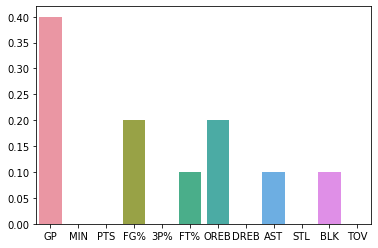

In [292]:
#L2 coefficients
model_best_l2 = LogisticRegression(
       penalty = 'l2',
       C = 0.00480719434510272,
       solver = 'lbfgs',
       class_weight = 'balanced')

model_best_l2.fit(X_train_reduce, y_train_reduce)
#dump(model_best_l2, '../models/model_best_l2.joblib')
#dump(best_l2, '../models/best_l2.joblib')

np.round(model_best_l2.coef_,1)
model_best_l2_coef = pd.DataFrame(np.round(model_best_l2.coef_,1), columns=df_analysis_reduce.columns)
sns.barplot(data=model_best_l2_coef)

The best model further reduces the features to only 6.

It shows that games played is the most important feature in predicting rookie longevity. 
FG% and offensive rebound appear to be the next important features, with FT%, ST, and BLK making minor contributions

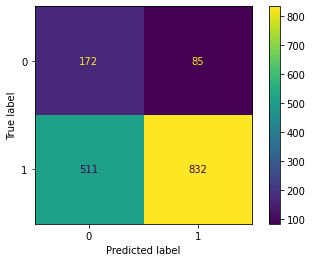

In [217]:
y_bestlogit =model_best_l2.predict(X_valid_reduce)
cm_bestlogit= confusion_matrix(y_valid_reduce, y_bestlogit, labels=model_best_l2.classes_)

dis_bestlogit= ConfusionMatrixDisplay(confusion_matrix=cm_bestlogit, display_labels=model_best_l2.classes_)
dis_bestlogit.plot()

The logit model has an accuracy rate of 62-67% for predicting rookies who make it >=5 years and <5 years.

<b> 2. Support Vector Classifier </b>

We are now going to see if we can improve the logit model with a support vector classifier model.

We are using a linear kernel as logit model suggests there might be a linear trend.

In [286]:
model_svc=SVC(class_weight='balanced',kernel='linear', probability = 1)
model_svc.fit(X_train_reduce, y_train_reduce)

SVC(class_weight='balanced', kernel='linear', probability=1)

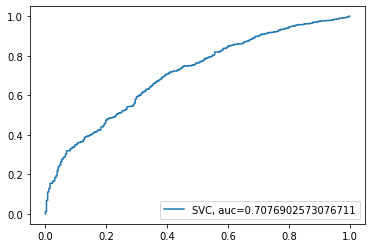

In [287]:
y_pred_proba_svc = model_svc.predict_proba(X_valid_reduce)[::,1]
fpr_, tpr_, _ = metrics.roc_curve(y_valid_reduce,  y_pred_proba_svc)
auc_svc = metrics.roc_auc_score(y_valid_reduce, y_pred_proba_svc)
plt.plot(fpr_,tpr_,label="SVC, auc="+str(auc_svc))
plt.legend(loc=4)
plt.show()

The AUC metric is similar to the logit model. We'll see if we can improve it with hyper parameter tuning

In [288]:
space_svc = {
   'C' : hp.uniform('C', 0, 100)
}

In [289]:
def objective_svc(space_svc):
   svc_model = SVC(
       C = space_svc['C'],
       kernel = 'linear',
       class_weight = 'balanced',
       probability = 1
   )
   svc_model.fit(X_train_reduce, y_train_reduce)
   auc = metrics.roc_auc_score(y_valid_reduce,svc_model.predict_proba(X_valid_reduce)[::,1])
   return{'loss': 1-auc, 'status': STATUS_OK }

In [294]:
best_svc = fmin(
   fn=objective_svc,  
   space=space_svc,      
   algo=tpe.suggest,      
   max_evals=5
)
best_svc

100%|██████████| 5/5 [17:23<00:00, 208.76s/trial, best loss: 0.2922778725833042] 


{'C': 85.50156716403585}

The hyper parameter tuning takes a long time to run and only improves the AUC slightly.

In [298]:
model_best_svc = SVC(
       C = 85.50156716403585,
       kernel = 'linear',
       class_weight = 'balanced',
       probability = 1
   )
model_best_svc.fit(X_train_reduce, y_train_reduce)

SVC(C=85.50156716403585, class_weight='balanced', kernel='linear',
    probability=1)

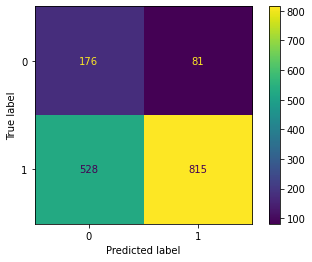

In [300]:
y_bestsvc =model_best_svc.predict(X_valid_reduce)
cm_svc= confusion_matrix(y_valid_reduce, y_bestsvc, labels=model_best_svc.classes_)

dis_svc= ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=model_best_svc.classes_)
dis_svc.plot()

The model produces a result that is similar to the logit model

In [325]:
imp_vals, _ = feature_importance_permutation(
    predict_method=model_best_svc.predict, 
    X=X_valid_reduce,
    y=y_valid_reduce,
    metric='accuracy',
    num_rounds=10,
    seed=1)


<AxesSubplot:>

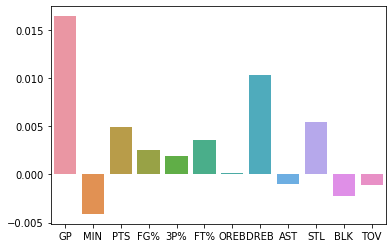

In [326]:
svc_importance = pd.DataFrame(np.round(imp_vals,4), index=df_analysis_reduce.columns).T
sns.barplot(data=svc_importance)

The SVC model indicates that games played is the most important predictor of a rookie's outcome. 
Unlike the logit model, it puts more weight on the influence of defensive rebound stats.

<b> Summary </b>

Optimising the hyper-parameters of the logistic regression model lead to a simpler model with improved AUC metric
and accuracy above 60% for both classes.

An alternative support vector classifier model was fitted to see if the optimised logistic regression model
could be improved upon. However, the SVC model produced similar results to the logistic regression model with slightly less
AUC metric. The model is more resource intensive than the logistic regression model (takes about 2 mins to run).

For its simplicity, ease of interpretability and reproducibility, I recommend the logistic regression model to be the
optimal model for predicting the NBA careers prospects of rookies in the dataset


In [327]:
#Preparing files for Kaggle Submissions
#Grab the test data
test_data=pd.read_csv('../data/raw/test.csv')
test_data_model = test_data.drop(columns=["Id_old","Id"])

In [328]:
test_data_model_red = test_data_model.drop(columns=["FGM","FGA","3P Made","3PA","FTM","FTA","REB"])
test_data_model_red_scaled=scaler.fit_transform(test_data_model_red)

In [331]:
model_best_logit_predprob = model_best_l2.predict_proba(test_data_model_red_scaled)[:,1]
submission_file_bestlogit = pd.DataFrame(model_best_logit_predprob, index=test_data['Id'])

submission_file_bestlogit.rename( columns={0 :'TARGET_5Yrs'}, inplace=True )
submission_file_bestlogit.to_csv('../data/processed/best_logit.csv' )